In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from ResNet import Bottleneck, ResNet, ResNet152

In [2]:

transform_train = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

transform_test = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

In [3]:
# Define your custom dataset class
class NumpyDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        
        self.data_files = []  # List to hold the paths to the image files
        self.labels = []      # List to hold the corresponding labels (folder names)

        # Walk through each class folder and collect image paths and labels
        for label, class_dir in enumerate(os.listdir(root_dir)):  # Label is the folder index
            
            class_path = os.path.join(root_dir, class_dir)
            
            if os.path.isdir(class_path):  # Ensure we're only looking at directories (classes)
                
                for file in os.listdir(class_path):
                    
                    if file.endswith('.npy'):  # Check if it's a .npy file
                        
                        file_path = os.path.join(class_path, file)
                        
                        self.data_files.append(file_path)  # Add the image path
                        self.labels.append(label)  # Use the index as the label (you can also store the class_dir string if needed)

        # Create a mapping from folder names (class names) to labels
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(root_dir))}


    def __len__(self):
        return len(self.data_files)


    def __getitem__(self, idx):
        
        img_path = self.data_files[idx]
        image = np.load(img_path)


        # Get the label for this image (corresponding folder)
        label = self.labels[idx]


        # Convert the image to a tensor and apply any transformations
        if self.transform:
            
            image = self.transform(image)

        return image, label


# Define your transformations (if any)
transform_train = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])



transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])




# Instantiate the custom dataset for training and testing
train_dataset = NumpyDataset(
    
    root_dir='C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original/training',
    transform=transform_train
)

test_dataset = NumpyDataset(
    
    root_dir='C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original/testing',
    transform=transform_test
)


# Create DataLoaders for both datasets
trainloader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers = 0)
testloader = DataLoader(test_dataset, batch_size = 64, shuffle=False, num_workers = 0)

In [4]:
net = ResNet152(2).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [5]:
# Training loop with loss tracking
EPOCHS = 200
train_losses = []  # List to store the average training loss per epoch

for epoch in range(EPOCHS):
    
    losses = []
    running_loss = 0
    
    for i, inp in enumerate(trainloader):
        
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
    
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 0 and i > 0:
            
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            
            running_loss = 0.0
     
        #print(epoch)
        print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
        

    avg_loss = sum(losses) / len(losses)
    
    train_losses.append(avg_loss)  # Track the average loss per epoch
    scheduler.step(avg_loss)

print('Training Done')

Loss [1, 0](epoch, minibatch):  0.007241166830062866
Loss [1, 1](epoch, minibatch):  0.1103389585018158
Loss [1, 2](epoch, minibatch):  0.22099655508995056
Loss [2, 0](epoch, minibatch):  0.09722896575927735
Loss [2, 1](epoch, minibatch):  0.14217291831970214
Loss [2, 2](epoch, minibatch):  0.8843799495697021
Loss [3, 0](epoch, minibatch):  0.20507766723632812
Loss [3, 1](epoch, minibatch):  0.30653578758239747
Loss [3, 2](epoch, minibatch):  1.304681463241577
Loss [4, 0](epoch, minibatch):  0.15595887184143067
Loss [4, 1](epoch, minibatch):  0.19238858461380004
Loss [4, 2](epoch, minibatch):  0.26760981798171996
Loss [5, 0](epoch, minibatch):  0.015760841369628905
Loss [5, 1](epoch, minibatch):  0.7256827163696289
Loss [5, 2](epoch, minibatch):  0.7926176881790161
Loss [6, 0](epoch, minibatch):  0.5180685424804687
Loss [6, 1](epoch, minibatch):  0.6261267185211181
Loss [6, 2](epoch, minibatch):  0.8368836688995361
Loss [7, 0](epoch, minibatch):  0.015907911062240602
Loss [7, 1](epoch,

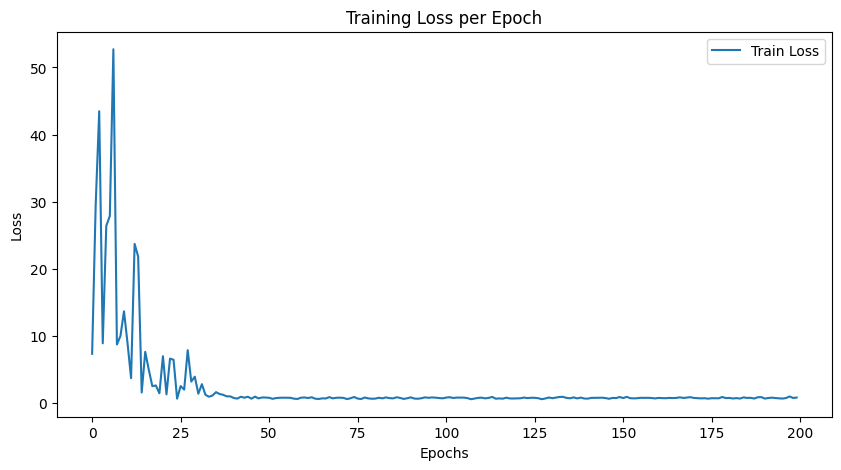

In [6]:
# Plotting the training loss per epoch
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
# Evaluation phase and classification report
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    
    for data in testloader:
        
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_preds.extend(predicted.cpu().numpy())  # Store predictions

accuracy = 100 * correct / total

print(f'Accuracy on test images: {accuracy}%')

Accuracy on test images: 50.75757575757576%


In [8]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(2)])

print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66        66
           1       0.60      0.05      0.08        66

    accuracy                           0.51       132
   macro avg       0.55      0.51      0.37       132
weighted avg       0.55      0.51      0.37       132



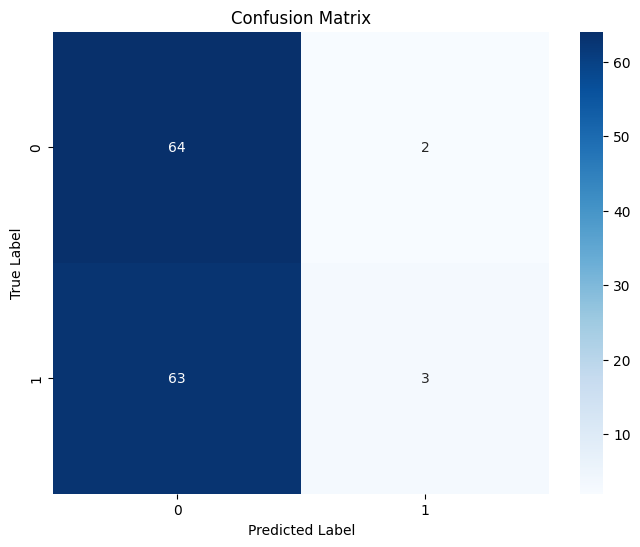

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(2)], yticklabels=[str(i) for i in range(2)])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [10]:
correct = 0
total = 0

with torch.no_grad():
    
    for data in testloader:
        
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        
print('Accuracy test images: ', 100*(correct/total), '%')

Accuracy test images:  50.75757575757576 %
